In [1]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import os
from scipy.misc import imresize
from mammo_utils import remove_white_from_image, slice_normal_image, create_slices, read_pgm
%matplotlib inline

In [2]:
base_path = "E:\\Documents\\Mammography\\MIAS\\pgms\\"

# import and clean the annotation data
all_cases_df = pd.read_table('data/Info.txt', delimiter=' ')
all_cases_df = all_cases_df[all_cases_df.columns[:-1]] # drop last column
all_cases_df['path'] = all_cases_df['REFNUM'].map(lambda x: '%s.pgm' % x)

# drop row 214 since it has problems
all_cases_df = all_cases_df.drop([214])
all_cases_df.reindex()

# add another column to indicate whether the scan is normal or not, disregarding the specific type of abnormality
all_cases_df['ABNORMAL'] = (all_cases_df['CLASS'] != 'NORM') * 1.0

# add one more column to indicate whether the abnormality is benign or malignant, malignant is 1, benign is 0, no abnormality is -1
all_cases_df['TYPE'] = -1
mal_idx = all_cases_df['SEVERITY'] == 'M'
all_cases_df.loc[mal_idx,'TYPE'] = 1
ben_idx = all_cases_df['SEVERITY'] == 'B'
all_cases_df.loc[ben_idx,'TYPE'] = 0

ddsm_images = np.load(os.path.join("data", "mass_test_slices.npy"))

In [3]:
# import an image to look at it
def draw_image_with_roi(idx):
    img_location = all_cases_df.iloc[idx]['path']
    
    x_center = all_cases_df.iloc[idx]['X']
    y_center = all_cases_df.iloc[idx]['Y']
    radius = all_cases_df.iloc[idx]['RADIUS']
 
    path = base_path + img_location
    
    img = read_pgm(path)

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.plot([x_center],[1024-y_center], 'ro')
    circle1 = plt.Circle((x_center, 1024-y_center), radius, color='r', fill=False)
    ax.add_artist(circle1)
    ax.set_title("Radius:" + str(radius))

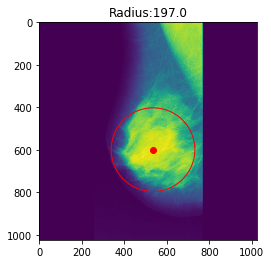

In [36]:
draw_image_with_roi(0)

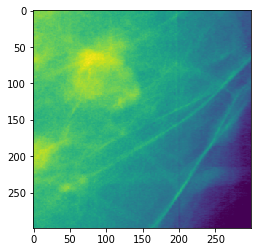

In [5]:
plt.imshow(ddsm_images[100].reshape((299,299)))

In [6]:
## draw images with a red circle for the ROI radius and a blue circle for the slice size
def draw_big_image_with_roi(idx):
    img_location = all_cases_df.iloc[idx]['path']
    print(img_location)
    x_center = all_cases_df.iloc[idx]['X'] * 2.5
    y_center = all_cases_df.iloc[idx]['Y'] * 2.5
    radius = all_cases_df.iloc[idx]['RADIUS'] * 2.5
    
    path = base_path + img_location
    
    img = read_pgm(path)
    img = imresize(img, (2560,2560))
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.plot([x_center],[2560-y_center], 'ro')
    circle1 = plt.Circle((x_center, 2560-y_center), radius, color='r', fill=False)
    circle2 = plt.Circle((x_center, 2560-y_center), 150, color='b', fill=False)
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.set_title("Radius:" + str(radius))
    
    return img

mdb001.pgm


C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


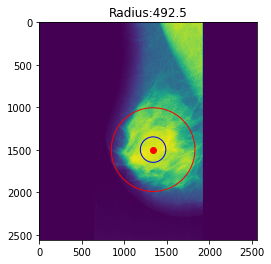

In [37]:
img0 = draw_big_image_with_roi(0)

mdb013.pgm


C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


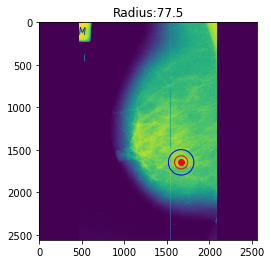

In [8]:
img9 = draw_big_image_with_roi(13)

In [112]:
def get_image_class(df, idx):
     # get the name of the image from the data
    img_name = df.loc[idx]['path']
    severity = df.loc[idx]['SEVERITY']
    img_class = df.loc[idx]['CLASS']
    
    if severity == "M":
        img_label = "MALIGNANT_"
        if img_class == "NORM":
            img_label = "NORMAL"
        elif img_class == "CALC":
            img_label = img_label + "calcification"
        else:
            img_label = img_label + "mass"
    elif severity == "B":
        img_label = "BENIGN_"
        if img_class == "CALC":
            img_label = img_label + "calcification"
        elif img_class == "NORM":
            img_label = "NORMAL"
        else:
            img_label = img_label + "mass"
    else:
        img_label = "NORMAL"
    
    return img_label
    
def create_mias_slices(df, base_path="E:\\Documents\\Mammography\\MIAS\\pgms\\", scale_by=2.5, verbose=True, var_upper_threshhold=1000, var_lower_threshhold=0, mean_threshold=23, mean_upper_threshhold=1000):    
    all_slices = []
    all_filenames = []
    all_labels = []
    
    # loop through each row in the dataframe
    for idx in df.index.values:
        # read the image in
        img_name = all_cases_df.loc[idx]['path']
        path = base_path + img_name
        img = read_pgm(path)
    
        # size it by 2.5x so it's on the same scale as the DDSM data
        new_size = int(1024 * scale_by)
        img = imresize(img, (new_size,new_size))
        
        # remove the black from the edges so we don't end up with black images
        img = img[:,np.sum(img == 0, axis=0) <= (img.shape[0] - 10)]
        
        img_h, img_w = img.shape
        
        # get the label so we know what to do with it
        image_label = get_image_class(df, idx)
        
        # if the image is abnormal slice the ROI out of it
        if image_label != "NORMAL":
            # some rows are improperly labeled, skip those
            if not np.isnan(df.loc[idx]['RADIUS']):
                radius = int(df.loc[idx]['RADIUS'] * scale_by)
                center_x = int(df.loc[idx]['X'] * scale_by)
                # the y coordinates are in a normal graph scale from bottom up so adjust for that
                center_y = 2560 - int(df.loc[idx]['Y'] * scale_by)
            else:
                continue
                
            # define the boundaries of the ROI, making sure they don't go over the edges of the image
            start_row = np.max([center_y - 150, 0])
            end_row = start_row + 299
            if end_row > img_h:
                end_row = img_h
                start_row = end_row - 299
            
            start_col = np.max([center_x - 150, 0])
            end_col = start_col + 299
            if end_col > img_w:
                end_col = img_w
                start_col = end_col - 299    
            
            # cut the ROI out at normal size
            img_slice = img[start_row:end_row, start_col:end_col]
            
            if img_slice.shape == (299,299):
                # reshape the image
                all_slices.append(img_slice.reshape((299,299,1)))
                all_labels.append(image_label)
                all_filenames.append(img_name)
            
        # else if the image is normal slice it up into multiple slices
        else:
            # cut off more of the edges of the image so we have usable content
            img = img[:,np.sum(img <= 20, axis=0) <= (img.shape[0] - 500)]
            
            # cut the image into tiles
            tiles = [img[x:x+299,y:y+299] for x in range(0,img.shape[0],299) for y in range(0,img.shape[1],299)]
            
            # loop through the tiles, if it has usable info add it, if not skip it
            for i in range(len(tiles)):
                # make sure tile has correct shape
                if tiles[i].shape == (299,299):
                    # make sure the tile doesn't contain white borders or letters
                    if np.sum(np.sum(tiles[i] >= 225)) < 100:
                        # make sure tile has stuff in it
                        if (np.mean(tiles[i]) >= mean_threshold) and (np.mean(tiles[i]) <= mean_upper_threshhold):
                            # make sure the tile contains image and not mostly empty space
                            if (np.var(tiles[i]) <= var_upper_threshhold) and (np.var(tiles[i]) >= var_lower_threshhold):
                                # this will give us a LOT more normal tiles than abnormal ones, to balance it a bit more
                                # let's randomly decide whether to use the tile or not with a probability of 1/3
                                coin = np.random.binomial(1, .3)
                                if coin:
                                    # reshape the tile so they will work with the convnet
                                    all_slices.append(tiles[i].reshape(299,299,1))
                                    all_filenames.append(img_name)
                                    all_labels.append("NORMAL")
            
        
    return np.array(all_slices), np.array(all_labels), np.array(all_filenames)

In [113]:
slices, labels, filenames = create_mias_slices(all_cases_df)

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [115]:
pd.value_counts(labels, normalize=True)

NORMAL                     0.896035
BENIGN_mass                0.046696
MALIGNANT_mass             0.034361
BENIGN_calcification       0.012335
MALIGNANT_calcification    0.010573
dtype: float64

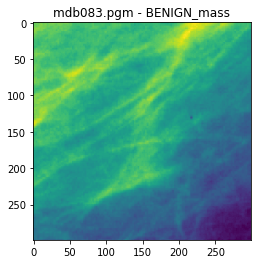

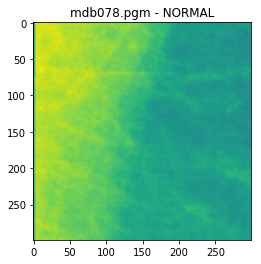

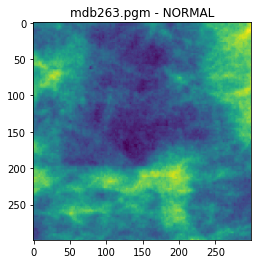

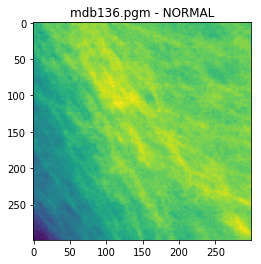

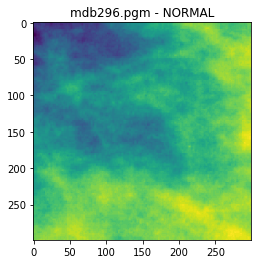

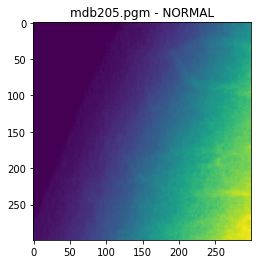

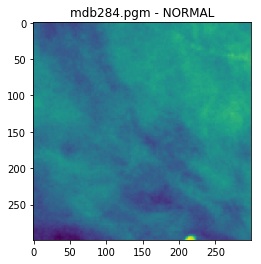

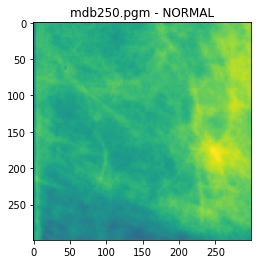

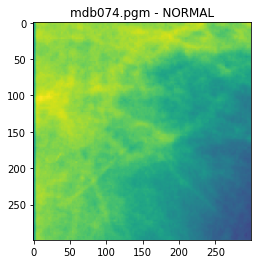

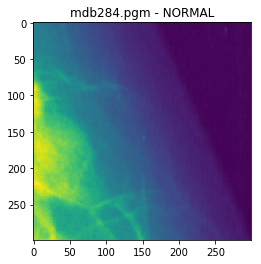

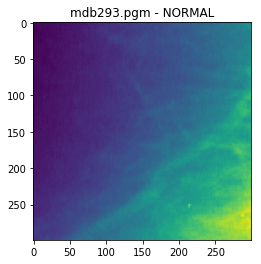

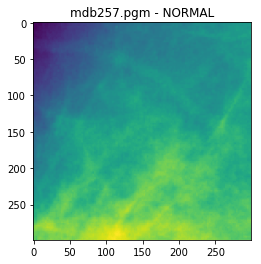

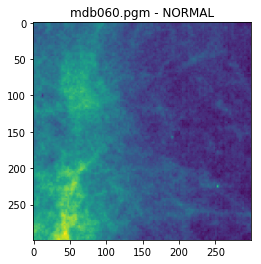

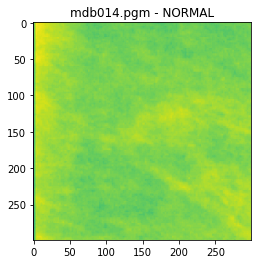

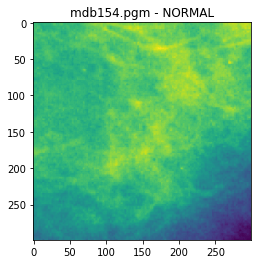

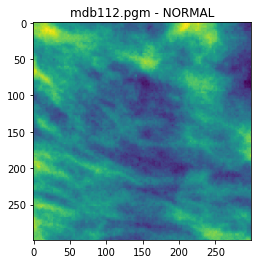

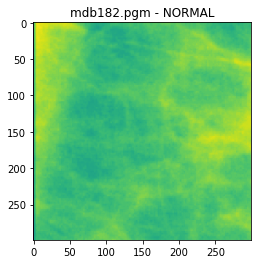

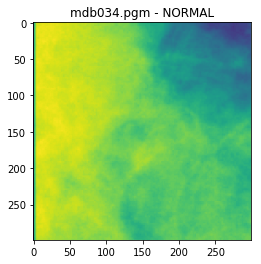

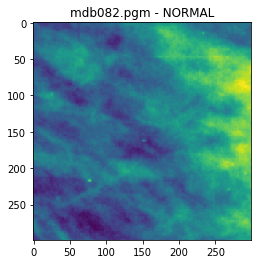

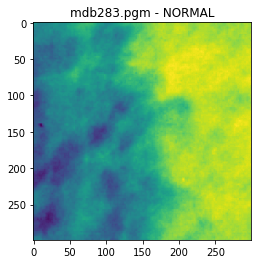

In [116]:
# look at some random images
N = 20
idxs = random.sample(range(len(slices)), k=N)

for idx in idxs:
    plt.imshow(slices[idx].reshape(299,299))
    plt.title(filenames[idx] + " - " + labels[idx])
    plt.show()

In [118]:
# save the data
np.save(os.path.join("data", "mias_test_images.npy"), slices)
np.save(os.path.join("data", "mias_test_labels.npy"), labels)
np.save(os.path.join("data", "mias_test_filenames.npy"), filenames)

## Old Abandoned Code

In [24]:
# given an image array and a factor to resize by do that and return the new image
def zoom_roi(img, roi_size, scale_factor):
    # get the size of the image
    img_size = img.shape[0]
    
    # calculcate the size to zoom to and the new roi size
    zoom_size = int(img_size * scale_factor)
    roi_size_scaled = roi_size * scale_factor
    
    # zoom the image out
    img_zoomed = imresize(img, (zoom_size, zoom_size))
    
    return img_zoomed, roi_size_scaled

def get_fuzzy_offset(roi_size, slice_size=299):
    fuzz_factor = (slice_size - roi_size - 20) // 2
    
    if fuzz_factor <= 0:
        fuzz_factor = 1
    
    fuzz_sign_h = np.random.binomial(1,0.5)
    fuzz_sign_w = np.random.binomial(1,0.5)

    fuzz_offset_w = np.random.randint(low=0, high=fuzz_factor)
    if fuzz_sign_w == 0:
        fuzz_offset_w = 0 - fuzz_offset_w

    fuzz_offset_h = np.random.randint(low=0, high=fuzz_factor)
    if fuzz_sign_h == 0:
        fuzz_offset_h = 0 - fuzz_offset_h
    
    return fuzz_offset_h, fuzz_offset_w

def get_roi_edges(center_col, center_row, img_size, fuzz_offset_w=0, fuzz_offset_h=0,scale_factor=1):
    # figure out the new center of the ROI
    center_col_scaled = int(center_col * scale_factor)
    center_row_scaled = int(center_row * scale_factor)

    start_col = center_col_scaled - 150 + fuzz_offset_h
    end_col = start_col + 299
    
    if start_col < 0:
        start_col = 0
        end_col = 299
    elif end_col > img_size:
        end_col = img_size
        start_col = img_size - 299
        
    start_row = center_row_scaled - 150 + fuzz_offset_w
    end_row = start_row + 299
    
    if start_row < 0:
        start_row = 0
        end_row = 299
    elif end_row > img_size:
        end_row = img_size
        start_row = img_size - 299   
    
    return start_row, end_row, start_col, end_col

def get_normal_slices(img, idx, var_upper_threshold=900, var_lower_threshold=50, mean_threshold=75, mean_upper_threshhold=200):
    # get the image name from the index
    img_name = all_cases_df.loc[idx]['path']
    
    # first trim the black from the edges
    img = img[:,np.sum(img == 0, axis=0) <= img.shape[0]]
    
    # slice the image into 299x299 tiles
    size = 299
    tiles = [img[x:x+size,y:y+size] for x in range(0,img.shape[0],size) for y in range(0,img.shape[1],size)]
    usable_tiles = []
    image_names = []
    labels = []
    
    # for each tile:
    for i in range(len(tiles)):
        # make sure tile has correct shape
        if tiles[i].shape == (size,size):
            if np.sum(np.sum(tiles[i] >= 225)) < 100:
                # make sure tile has stuff in it
                if (np.mean(tiles[i]) >= mean_threshold) and (np.mean(tiles[i]) <= mean_upper_threshhold):
                    # make sure the tile contains image and not mostly empty space
                    if np.var(tiles[i]) <= var_upper_threshold:
                        if np.var(tiles[i]) >= var_lower_threshold:
                            # reshape the tile so they will work with the convnet
                            usable_tiles.append(tiles[i].reshape(299,299,1))
                            image_names.append(img_name)
                            labels.append("NORMAL")
                            
    return usable_tiles, image_names, labels

# remove a slice of size 299x299 from the bigger image
def get_image_slice(idx, scale_by=2.5):
    # initialize the list to return
    slices = []
    names = []
    labels = []
    
    # get the name of the image from the data
    img_name = all_cases_df.loc[idx]['path']
    path = base_path + img_name
    severity = all_cases_df.loc[idx]['SEVERITY']
    img_class = all_cases_df.loc[idx]['CLASS']
    
    if severity == "M":
        img_label = "MALIGNANT_"
        if img_class == "NORM":
            img_label = "NORMAL"
        elif img_class == "CALC":
            img_label = img_label + "calcification"
        else:
            img_label = img_label + "mass"
    elif severity == "B":
        img_label = "BENIGN_"
        if img_class == "CALC":
            img_label = img_label + "calcification"
        elif img_class == "NORM":
            img_label = "NORMAL"
        else:
            img_label = img_label + "mass"
    else:
        img_label = "NORMAL"
    
    
    # read the image in
    img = read_pgm(path)
    
    # scale the image
    new_size = int(1024 * scale_by)
    img = imresize(img, (new_size,new_size))
    
    # if the image does NOT have an abnormality skip it for now, this will be 
    # filled in later to get normal test images
    if np.isnan(all_cases_df.loc[idx]['X']):
        return get_normal_slices(img, idx)
    
    # get the center of the abnormality
    center_col = int(all_cases_df.loc[idx]['X'] * scale_by)
    center_row = int(new_size - (all_cases_df.loc[idx]['Y'] * scale_by))
    
    # get the radius of the ROI
    radius = math.ceil(all_cases_df.loc[idx]['RADIUS'] * scale_by)
    roi_size = radius * 2
    #print("ROI Size:", roi_size)
    
    # if the ROI is small enough to fit into one slice without any zooming do that
    if roi_size <= 269:
        fuzz_offset_h, fuzz_offset_w = get_fuzzy_offset(roi_size)
        
        # define boundaries for the abnormality
        start_row, end_row, start_col, end_col = get_roi_edges(center_col, center_row, new_size, fuzz_offset_w, fuzz_offset_h, 1)
        
        # slice the ROI out of the image
        img_slice = img[start_row:end_row, start_col:end_col]
        
        # add to the list
        slices.append(img_slice)
        names.append(img_name)
        labels.append(img_label)
        
    # else if the ROI is too big we will zoom it out
    else:
        # figure out how much to zoom it out
        size_with_margin = roi_size + 60
        scale_factor = np.min([299 / size_with_margin, 2])
        zoom_size = int(new_size * scale_factor)
        size_scaled = radius * 2 * scale_factor
        
        # zoom the image out
        img_slice_2 = imresize(img, (zoom_size, zoom_size))
        
        fuzz_offset_h, fuzz_offset_w = get_fuzzy_offset(size_scaled)
        
        # figure out the new center of the ROI
        center_col_zoom = int(center_col * scale_factor)
        center_row_zoom = int(center_row * scale_factor)
        
        start_row_zoom, end_row_zoom, start_col_zoom, end_col_zoom = get_roi_edges(center_col, center_row, zoom_size, fuzz_offset_w, fuzz_offset_h,scale_factor)
        
        # cut the slice out
        img_slice_2 = img_slice_2[start_row_zoom:end_row_zoom, start_col_zoom:end_col_zoom]
  
        slices.append(img_slice_2)
        names.append(img_name)
        labels.append(img_label)
        
        # zoom it out again so we have more images to test with
        scale_factor = scale_factor * .75
        zoom_size = int(new_size * scale_factor)
        size_scaled = radius * 2 * scale_factor
        
        # slice the image and flip it
        img_slice_2 = imresize(img, (zoom_size, zoom_size))
        img_slice_2 = np.fliplr(img_slice_2)
        
        fuzz_offset_h, fuzz_offset_w = get_fuzzy_offset(size_scaled)
        
        # figure out the new center of the ROI
        center_col_zoom = int(center_col * scale_factor)
        center_row_zoom = int(center_row * scale_factor)
        
        start_row_zoom, end_row_zoom, start_col_zoom, end_col_zoom = get_roi_edges(center_col, center_row, zoom_size, fuzz_offset_w, fuzz_offset_h,scale_factor)
        
        # cut the slice out
        img_slice_2 = img_slice_2[start_row_zoom:end_row_zoom, start_col_zoom:end_col_zoom]
  
        slices.append(img_slice_2)
        names.append(img_name)
        labels.append(img_label)
        
    # if the ROI is small also zoom it in
    if roi_size <= 180:
        size_with_margin = roi_size + 60
        scale_factor = 1.5
        zoom_size = int(new_size * scale_factor)
        size_scaled = roi_size * scale_factor
        
        # zoom the image
        img_slice_3, size_scaled = zoom_roi(img, roi_size, scale_factor)
        
        # get the fuzzy offsets
        fuzz_offset_h, fuzz_offset_w = get_fuzzy_offset(size_scaled)
        
        # get the edges of the area
        start_row_zoom, end_row_zoom, start_col_zoom, end_col_zoom = get_roi_edges(center_col, center_row, zoom_size, fuzz_offset_w, fuzz_offset_h,scale_factor)
        
        # slice the ROI
        img_slice_3 = img_slice_3[start_row_zoom:end_row_zoom, start_col_zoom:end_col_zoom]
    
        slices.append(img_slice_3)
        names.append(img_name)
        labels.append(img_label)
        
    # return the slice
    return np.array(slices).reshape((-1,299,299,1)), names, labels

def create_slices(df, output=True, var_upper_threshhold=0, var_lower_threshhold=0, mean_threshold=0):
    all_slices = []
    all_filenames = []
    all_labels = []
    
    i = 0
    for idx in df.index.values:
        tiles, filenames, labels = get_image_slice(idx)
        j = 0
        for j in range(len(tiles)):
            all_slices.append(tiles[j])
            all_filenames.append(filenames[j])
            all_labels.append(labels[j])
            
    assert(len(all_slices) == len(all_labels))
    
    return np.array(all_slices), np.array(all_filenames), np.array(all_labels)

In [25]:
mias_slices, mias_filenames, mias_labels = create_slices(all_cases_df)

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [26]:
print("Slices:", mias_slices.shape)
print("Labels:", mias_labels.shape)
print("Filenames:", mias_filenames.shape)

Slices: (2431, 299, 299, 1)
Labels: (2431,)
Filenames: (2431,)


In [27]:
pd.value_counts(mias_labels, normalize=True)

NORMAL                     0.915673
BENIGN_mass                0.036199
MALIGNANT_mass             0.029206
BENIGN_calcification       0.011518
MALIGNANT_calcification    0.007404
dtype: float64

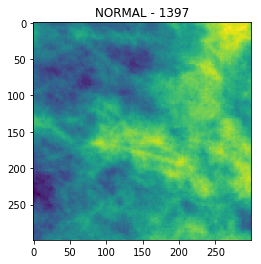

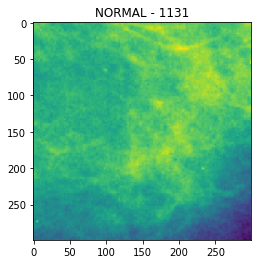

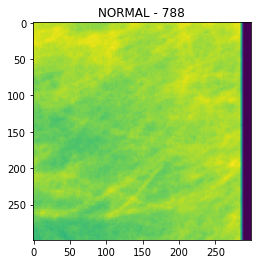

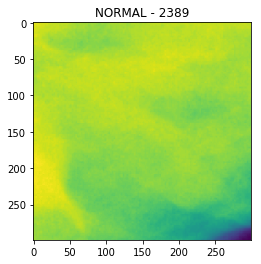

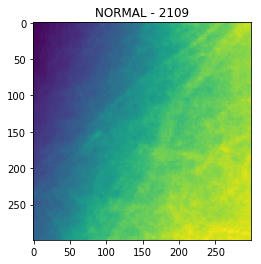

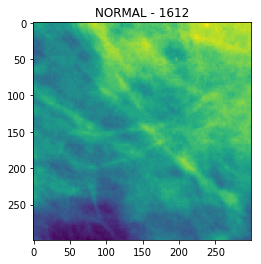

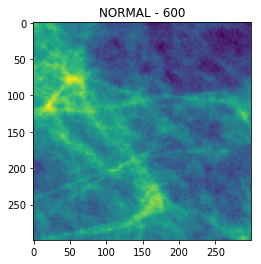

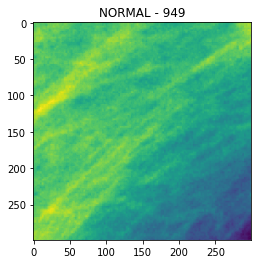

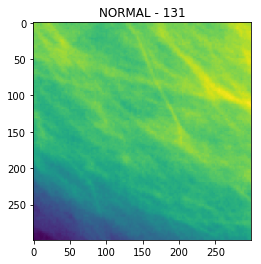

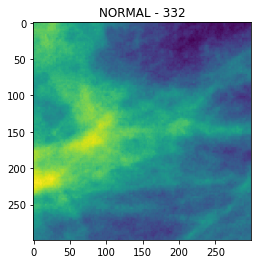

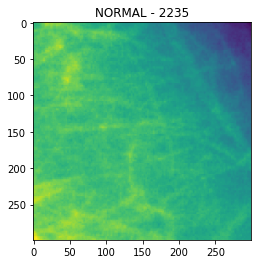

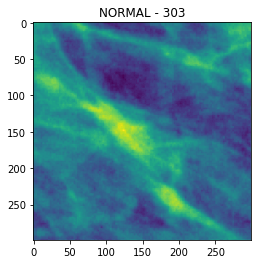

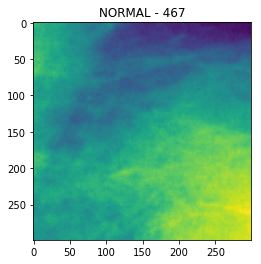

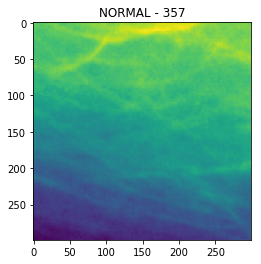

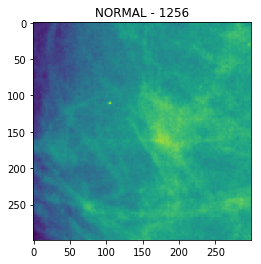

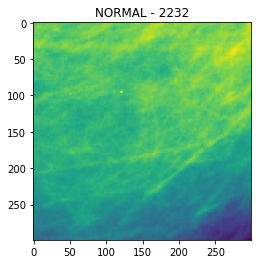

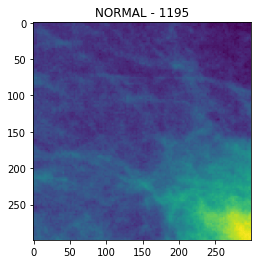

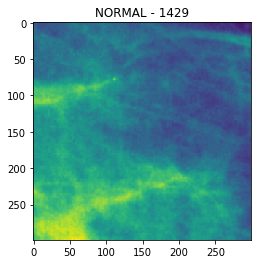

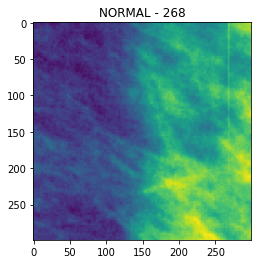

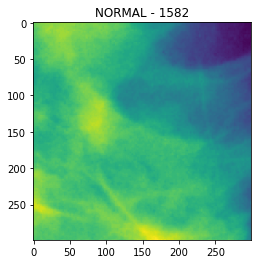

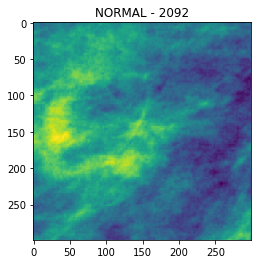

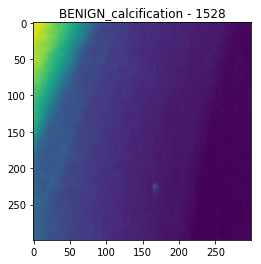

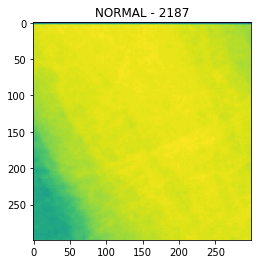

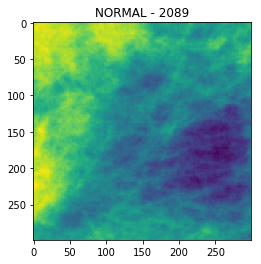

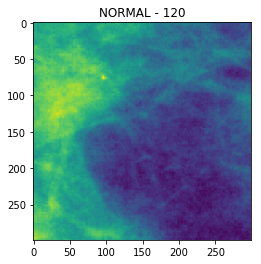

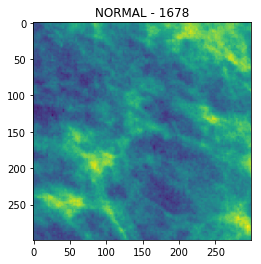

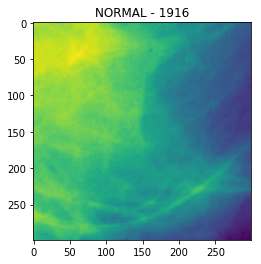

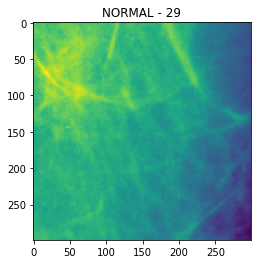

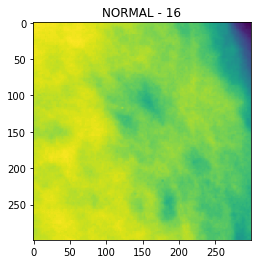

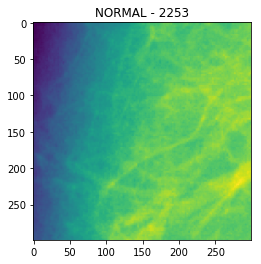

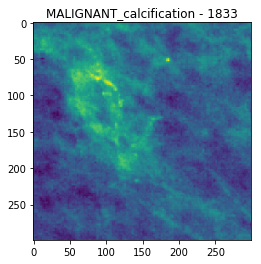

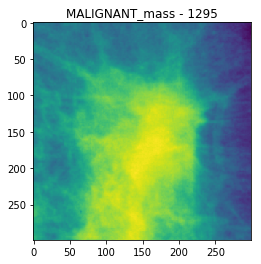

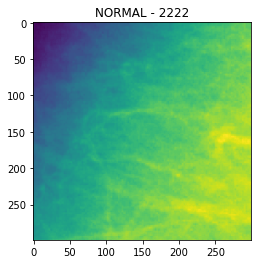

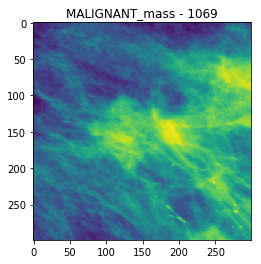

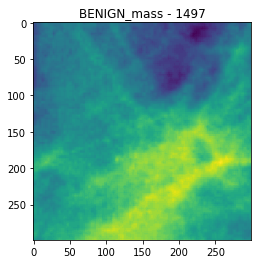

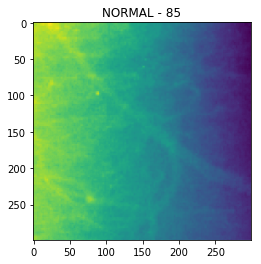

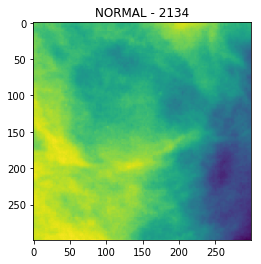

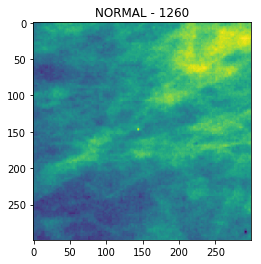

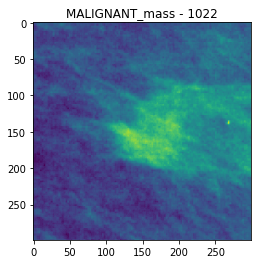

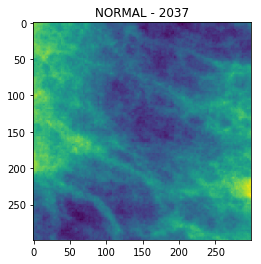

In [28]:
# get some random images
N = 40
idxs = random.sample(range(len(mias_slices)), k=N)

for idx in idxs:
    plt.imshow(mias_slices[idx].reshape(299,299))
    plt.title(mias_labels[idx] + " - " + str(idx))
    plt.show()